# Noise Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [7]:
import numpy as np
import pandas as pd
from pprint import pprint
from guess_range import *

## Visualize HW Behavior

In [8]:
def compute_corr(secret_hw, guess_range, known_inputs, guess_val_size=1000):
    low, high = guess_range
    guess_val = np.arange(low, high, (high - low) / (guess_val_size - 1e-127))
    hw = pd.DataFrame(columns=guess_val,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_val))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [9]:
guess_range=(0, 5e0)
# the number of guess values in the guess range
guess_val_size=1000
# generate the known inputs which is used to test the guess values
input_range = 2
known_inputs = np.random.uniform(-10 ** input_range, 10 ** input_range, 1000)

secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = 1.6890826472023605
print('secret_number =', secret_number)

secret_number = 1.6890826472023606


In [10]:
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
correlations = compute_corr(secret_hw, guess_range, known_inputs, guess_val_size)
correlations_1 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size*10))
correlations_2 = compute_corr(secret_hw, guess_range, known_inputs, int(guess_val_size/10))
correlations.sort_values(ascending=False).iloc[:10]

1.690    0.338681
1.685    0.292634
1.695    0.267075
3.380    0.265638
3.375    0.262647
0.845    0.256761
3.385    0.240044
1.680    0.235019
3.370    0.221353
1.710    0.216066
dtype: float64

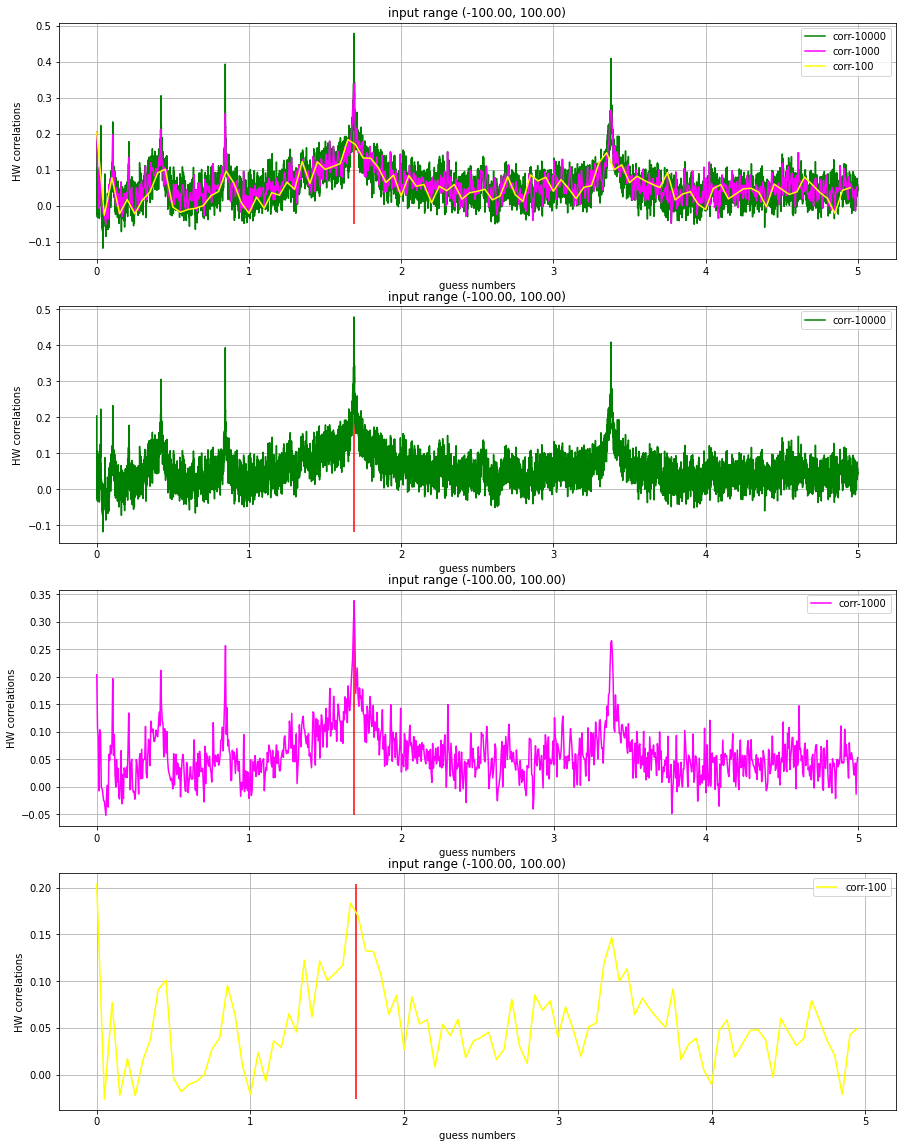

In [11]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
correlations_1.plot(ax=ax[0], label='corr-%s' % correlations_1.shape[0], color='green')
correlations.plot(ax=ax[0], label='corr-%s' % correlations.shape[0], color='magenta')
correlations_2.plot(ax=ax[0], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[0].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_1.plot(ax=ax[1], label='corr-%s' % correlations_1.shape[0], color='green')
ax[1].vlines(secret_number, correlations_1.min(), correlations_1.max(), color='red')

correlations.plot(ax=ax[2], label='corr-%s' % correlations.shape[0], color='magenta')
ax[2].vlines(secret_number, correlations.min(), correlations.max(), color='red')

correlations_2.plot(ax=ax[3], label='corr-%s' % correlations_2.shape[0], color='yellow')
ax[3].vlines(secret_number, correlations_2.min(), correlations_2.max(), color='red')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('guess numbers')
    a.set_ylabel('HW correlations')
    a.set_title('input range (%.02f, %.02f)' % (-10 ** input_range, 10 ** input_range))
    
plt.show()

## Correlation of mantissa

In [12]:
max_mantissa_nbits = 16
two_powers = 1 / np.asarray([np.power(2.0, i) for i in np.arange(0, max_mantissa_nbits)])

def _compute_mantisa(n):
    retval = 0.0
    s = "{0:b}".format(n)
    l = len(s)
    for idx in range(l):
        if s[l-idx-1] == '1':
            retval = retval + two_powers[idx]
    return retval

def build_guess_values(value_type='mantissa', numbers=None, mantissa_nbits=10, guess_range=None):
    if value_type == 'mantissa':
        if mantissa_nbits > max_mantissa_nbits:
            raise ValueError('the mantissa_nbits value is not supported')
        guess_numbers = np.vectorize(_compute_mantisa)(np.arange(0, np.power(2, mantissa_nbits)))
    elif value_type == 'exponent':
        exponent_nbits = 8
        exponents = np.arange(0, np.power(2.0, exponent_nbits)) - 127
        two_exponents = np.vectorize(lambda x: np.power(2.0, x) if x >= 0 else 1.0/np.power(2.0, -x))(exponents)
        x = (np.asarray(numbers) * two_exponents.reshape(-1, 1)).reshape(-1)
        guess_numbers = x[(guess_range[0] <= x) & (x <= guess_range[1])]
    elif value_type == 'sign':
        y = np.concatenate((np.asarray(numbers), -np.asarray(numbers)))
        guess_numbers = y[(guess_range[0] <= y) & (y <= guess_range[1])]        
    else:
        raise ValueError('the value_type is not supported')
    return guess_numbers

def compute_corr_numbers(secret_hw, known_inputs, guess_numbers):
    hw = pd.DataFrame(columns=guess_numbers,
                        data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_numbers))
    return hw.corrwith(pd.Series(secret_hw), method='pearson')

In [13]:
guess_numbers = build_guess_values(value_type='mantissa', mantissa_nbits=10, guess_range=guess_range)

In [14]:
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

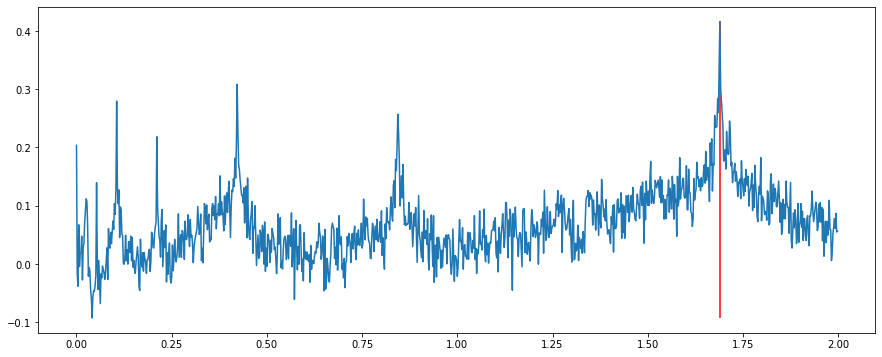

In [15]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [16]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.689453    0.416406
1.687500    0.339083
0.421875    0.308595
1.691406    0.302991
1.683594    0.284174
1.693359    0.281211
0.105469    0.279724
1.685547    0.260079
0.843750    0.257144
1.695312    0.256364
dtype: float64

## Correlation exponent

In [17]:
guess_numbers = build_guess_values(value_type='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)

mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

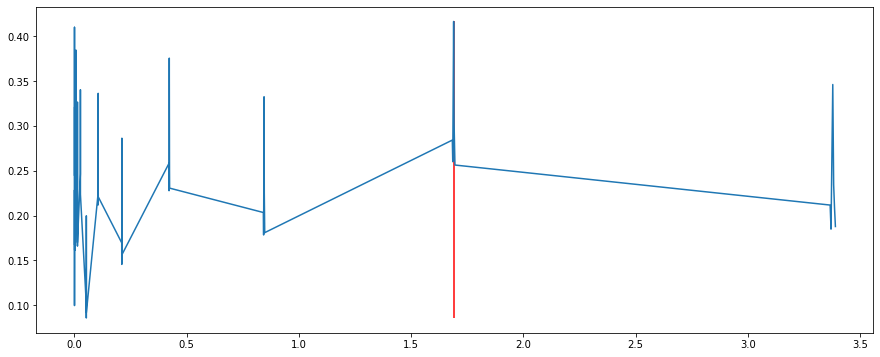

In [18]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [19]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

1.689453e+00    0.416406
9.158544e-20    0.409887
2.132390e-29    0.402375
3.933565e-10    0.402375
6.002143e-15    0.393899
2.577901e-05    0.393899
1.397483e-24    0.393899
3.253768e-34    0.393899
3.663417e-19    0.386760
1.465367e-18    0.385632
dtype: float64

## Correlation sign

In [20]:
guess_numbers = build_guess_values(value_type='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)

full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

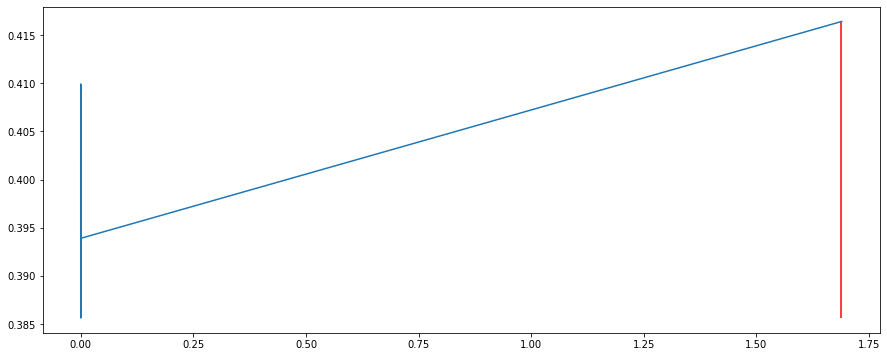

In [21]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [22]:
full_number_corr.sort_values(ascending=False).iloc[:10]

1.689453e+00    0.416406
9.158544e-20    0.409887
3.933565e-10    0.402375
2.132390e-29    0.402375
3.253768e-34    0.393899
1.397483e-24    0.393899
2.577901e-05    0.393899
6.002143e-15    0.393899
3.663417e-19    0.386760
1.465367e-18    0.385632
dtype: float64

## Analyze with noise - one number

In [67]:
def resize_known_inputs(known_inputs, new_len):
    """
    resize the known input to the new_len
    :param known_inputs: known inputs 
    :param new_len: new size of the know_inputs
    :return: the known
    """
    old_len = len(known_inputs)
    vf = np.vectorize(lambda i: known_inputs[int(i*old_len/new_len)])
    return vf(np.arange(0, new_len))

In [68]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [15]:
# the noise frequency is 50 times higher than HW signal frequency. Here we also increase
# the sizes of the computation with 
no_noise_secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

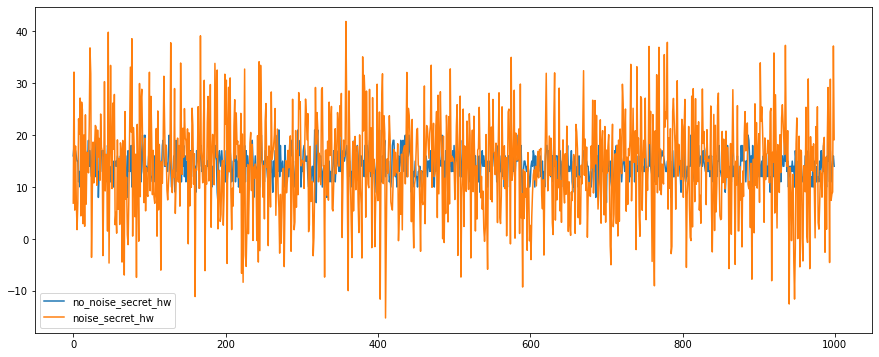

In [32]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_hw = add_noise_to_signal(signal=no_noise_secret_hw, snr=signal_to_noise_ratio, freq=10)
ax = pd.DataFrame([no_noise_secret_hw, noise_secret_hw], index=['no_noise_secret_hw', 'noise_secret_hw']).T.plot(figsize=(15,6))
ax.legend()

In [17]:
noise_correlations = compute_corr(noise_secret_hw, guess_range, known_inputs, guess_val_size)
print('secret_number =', secret_number)
noise_correlations.sort_values(ascending=False).iloc[:10]

secret_number = 0.8890826472023605


0.631    0.099349
0.829    0.098912
0.654    0.098219
0.810    0.093871
0.985    0.092549
0.816    0.091118
0.327    0.088646
0.890    0.087812
0.926    0.085756
0.764    0.084888
dtype: float64

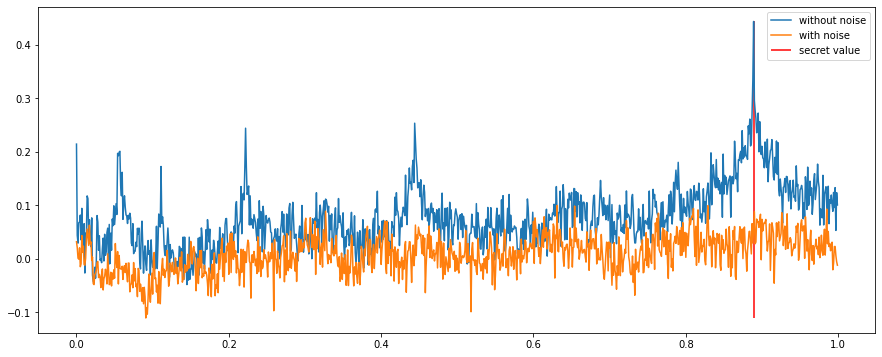

In [18]:
ax = correlations.plot(figsize=(15, 6), label='without noise')
noise_correlations.plot(ax=ax, label='with noise')
ax.vlines(secret_number, 
          min(noise_correlations.min(), correlations.min()),
          max(noise_correlations.max(), correlations.max()), 
          color='red', label='secret value')
ax.legend()

## Analyze with noise - multiple numbers

In [19]:
guess_range = (0.0, 5.0)
known_input_set = generate_known_inputs(exps=(-2,3), nsize=3000)
precision = 1e-6
n_secret_numbers = 10
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (9,)


In [20]:
secret_numbers_hws = {}
for idx in known_input_set.index:
    secret_numbers_hws[idx] = pd.DataFrame(
        columns=secret_numbers, 
        data=np.vectorize(hamming_weight)(np.asarray(known_input_set.loc[idx]).reshape(-1, 1) * secret_numbers))

In [21]:
secret_numbers_hws[0]

,3.833182,0.073441,2.235623,0.556674,0.163437,0.360563,2.023503,4.095178,1.376555
0,12,17,17,19,16,16,14,15,18
1,22,19,18,17,21,12,20,22,16
2,20,16,20,23,21,14,16,18,15
3,14,19,23,21,20,17,18,12,15
4,12,16,17,12,18,20,20,18,15
...,...,...,...,...,...,...,...,...,...
495,11,19,22,14,19,18,16,10,17
496,21,18,19,15,15,21,20,21,22
497,17,14,19,15,14,21,15,18,18
498,17,22,17,17,16,15,19,15,17


In [22]:
SECRET_VALUE='secret value'
df_index = [INPUT_ID, LOW_VALUE, HIGH_VALUE, CORRELATION, SECRET_VALUE]

In [23]:
%%time
# start guessing... - without noise first
results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        results = pd.concat([results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[3.833182] -2 3.833181 3.833182 0.999846'
'[3.833182] -1 3.833181 3.833182 0.998507'
'[3.833182] 00 3.833181 3.833182 0.999840'
'[3.833182] 01 3.833181 3.833182 0.999865'
'[3.833182] 02 0.000000 0.000001 0.311181'
'[3.833182] 03 3.833181 3.833182 1.000000'
'[0.073441] -2 1.175060 1.175061 0.975251'
'[0.073441] -1 1.175060 1.175061 0.993978'
'[0.073441] 00 1.175060 1.175061 0.991689'
'[0.073441] 01 4.700241 4.700242 0.886917'
'[0.073441] 02 0.073441 0.073442 0.999496'
'[0.073441] 03 1.175060 1.175061 0.947463'
'[2.235623] -2 2.235623 2.235624 1.000000'
'[2.235623] -1 2.235623 2.235624 0.999838'
'[2.235623] 00 2.235623 2.235624 0.999906'
'[2.235623] 01 2.235623 2.235624 1.000000'
'[2.235623] 02 2.235623 2.235624 1.000000'
'[2.235623] 03 2.235623 2.235624 0.999419'
'[0.556674] -2 0.556674 0.556675 0.999370'
'[0.556674] -1 0.556674 0.556675 0.996515'
'[0.556674] 00 2.226697 2.226697 0.852091'
'[0.556674] 01 0.556674 0.556675 0.995219'
'[0.556674] 02 0.556674 0.556675 0.999129'
'[0.556674]

In [33]:
### Add noise to hamming weight of the multiplication of the secret number
signal_to_noise_ratio = 0.5
noise_secret_numbers_hws = {}
for k in secret_numbers_hws.keys():
    noise_secret_numbers_hws[k] = secret_numbers_hws[k].apply(lambda hw: add_noise_to_signal(signal=hw, snr=signal_to_noise_ratio, freq=200), axis=0)
noise_secret_numbers_hws[0]    

,3.833182,0.073441,2.235623,0.556674,0.163437,0.360563,2.023503,4.095178,1.376555
0,13.529434,15.239385,16.231741,17.955517,11.754407,15.467747,12.753016,13.093057,12.824315
1,19.871627,16.468094,22.686541,18.549294,19.556955,12.985124,20.076944,25.284823,16.132723
2,23.685206,13.287715,19.779575,17.834588,21.911617,11.066443,13.266701,21.450378,11.536225
3,12.750482,20.731252,20.520484,24.394700,19.793853,18.911022,16.782746,12.792709,11.097544
4,10.194049,14.243326,13.948992,12.066602,16.468874,21.096085,20.404073,19.210653,17.658383
...,...,...,...,...,...,...,...,...,...
495,11.082825,16.838010,23.543469,16.063011,19.525935,19.248174,17.086008,9.163562,15.951146
496,17.175624,15.193892,23.116648,14.691527,14.219222,16.278216,22.601094,18.299695,24.828704
497,22.684798,13.679196,18.449149,15.695142,12.645871,22.031912,15.510764,13.897922,15.543849
498,16.829938,24.087885,16.958509,18.509126,14.306325,13.230941,16.878758,16.908736,16.270523


In [34]:
%%time
# start guessing... - with noise
noise_results = pd.DataFrame()
for value in secret_numbers:
    for kidx in known_input_set.index:
        l, h, c = guess_number_range(noise_secret_numbers_hws[kidx][value], guess_range, precision, known_input_set.loc[kidx])
        pprint('[%.06f] %02d %.06f %.06f %.06f' % (value, kidx, l, h, c))
        noise_results = pd.concat([noise_results, pd.Series([kidx, l, h, c, value], index=df_index)], axis=1, ignore_index=True)

'[3.833182] -2 3.833181 3.833182 0.749569'
'[3.833182] -1 3.833181 3.833182 0.790645'
'[3.833182] 00 3.833181 3.833182 0.811339'
'[3.833182] 01 3.833181 3.833182 0.761414'
'[3.833182] 02 0.000000 0.000001 0.236710'
'[3.833182] 03 3.833181 3.833182 0.721174'
'[0.073441] -2 1.175060 1.175061 0.752244'
'[0.073441] -1 1.175060 1.175061 0.755084'
'[0.073441] 00 1.175060 1.175061 0.746345'
'[0.073441] 01 4.700241 4.700242 0.680010'
'[0.073441] 02 0.073441 0.073442 0.794306'
'[0.073441] 03 0.073441 0.073442 0.695633'
'[2.235623] -2 2.235623 2.235624 0.734515'
'[2.235623] -1 2.235623 2.235624 0.793409'
'[2.235623] 00 2.235623 2.235624 0.796751'
'[2.235623] 01 2.235623 2.235624 0.740211'
'[2.235623] 02 2.235623 2.235624 0.753040'
'[2.235623] 03 2.235623 2.235624 0.755373'
'[0.556674] -2 0.000000 0.000001 0.207968'
'[0.556674] -1 0.556674 0.556675 0.763949'
'[0.556674] 00 0.556674 0.556675 0.785446'
'[0.556674] 01 0.556674 0.556675 0.741524'
'[0.556674] 02 0.556674 0.556675 0.790449'
'[0.556674]

### Statistics

In [35]:
GUESSED_VALUE = 'guessed value'
ERROR = 'error'
def statistics(df):
    dft = df.T
    dft[GUESSED_VALUE] = (dft[HIGH_VALUE]+dft[LOW_VALUE])/2.0
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [36]:
best_corr, best_err = statistics(results)
noise_best_corr, noise_best_err = statistics(noise_results)

In [37]:
noise_best_corr

,10,25,33,22,52,41,14,2,44
input id,2.000000,-1.000000,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
low value,0.073441,2.614988,3.605622e-01,5.566740e-01,1.376555e+00,2.023502e+00,2.235623e+00,3.833181e+00,4.095178e+00
high value,0.073442,2.614989,3.605628e-01,5.566746e-01,1.376556e+00,2.023503e+00,2.235624e+00,3.833182e+00,4.095178e+00
correlation,0.794306,0.755976,8.141346e-01,7.904489e-01,7.917871e-01,7.968702e-01,7.967511e-01,8.113386e-01,8.170139e-01
secret value,0.073441,0.163437,3.605628e-01,5.566742e-01,1.376555e+00,2.023503e+00,2.235623e+00,3.833182e+00,4.095178e+00
guessed value,0.073442,2.614988,3.605625e-01,5.566743e-01,1.376555e+00,2.023502e+00,2.235623e+00,3.833182e+00,4.095178e+00
error,0.000004,15.000000,7.265185e-07,1.574797e-07,1.437027e-07,1.216025e-07,1.458243e-08,6.576451e-08,4.477847e-08


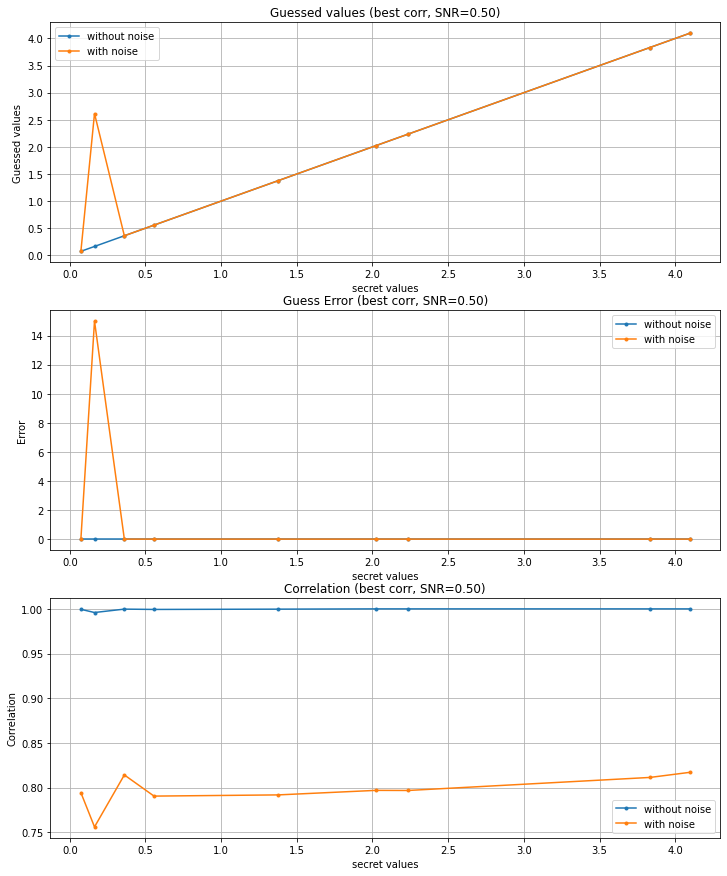

In [38]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

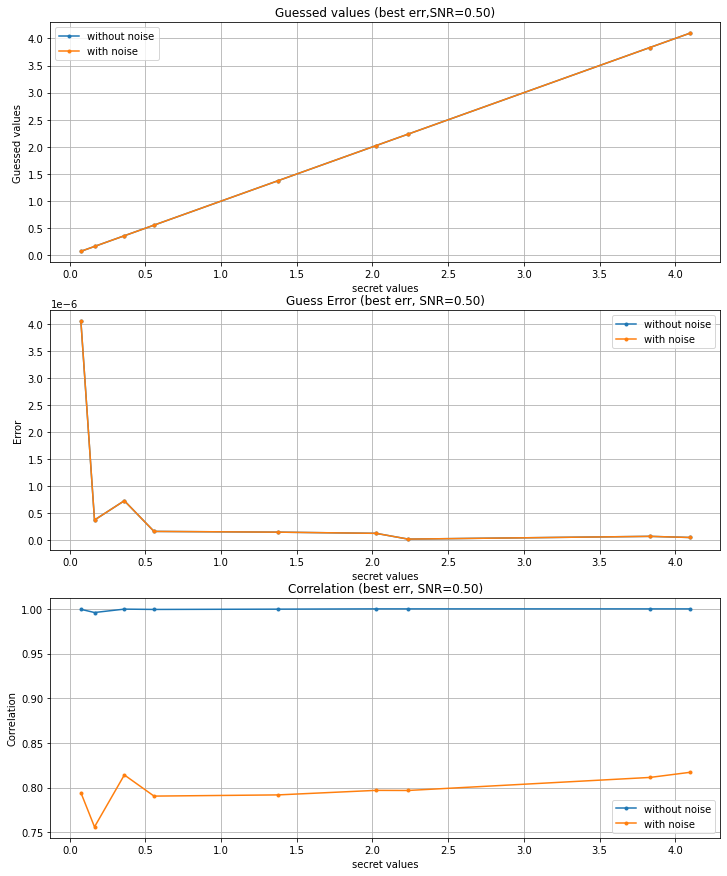

In [39]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_best_err.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (best err,SNR=%0.2f)' % signal_to_noise_ratio)


df = best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_best_err.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (best err, SNR=%0.2f)' % signal_to_noise_ratio)

df = best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (best err, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()

In [40]:
best_err

,10,27,33,18,48,36,12,0,42
input id,2.000000,1.000000e+00,1.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00
low value,0.073441,1.634365e-01,3.605622e-01,5.566740e-01,1.376555e+00,2.023502e+00,2.235623e+00,3.833181e+00,4.095178e+00
high value,0.073442,1.634371e-01,3.605628e-01,5.566746e-01,1.376556e+00,2.023503e+00,2.235624e+00,3.833182e+00,4.095178e+00
correlation,0.999496,9.956535e-01,9.997338e-01,9.993696e-01,9.992988e-01,1.000000e+00,1.000000e+00,9.998462e-01,1.000000e+00
secret value,0.073441,1.634368e-01,3.605628e-01,5.566742e-01,1.376555e+00,2.023503e+00,2.235623e+00,3.833182e+00,4.095178e+00
guessed value,0.073442,1.634368e-01,3.605625e-01,5.566743e-01,1.376555e+00,2.023502e+00,2.235623e+00,3.833182e+00,4.095178e+00
error,0.000004,3.688735e-07,7.265185e-07,1.574797e-07,1.437027e-07,1.216025e-07,1.458243e-08,6.576451e-08,4.477847e-08
